<a href="https://colab.research.google.com/github/uprestel/Matrix-Completion/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressed Sensing - Matrix completion project

In this project we explore the DRS and FISTA algorithms within the framework of the matrix completion problem.

We apply said algorithms to image inpainting / reconstruction and the Netflix problem.

---



In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # If we are in colab, we download the data from the repository
    !git -C Matrix-Completion pull || git clone https://github.com/uprestel/Matrix-Completion.git
    %cd Matrix-Completion/

fatal: cannot change to 'Matrix-Completion': No such file or directory
Cloning into 'Matrix-Completion'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 182 (delta 52), reused 9 (delta 1), pack-reused 74
Receiving objects: 100% (182/182), 10.60 MiB | 13.41 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/Matrix-Completion


## Image inpainting / completion

We start off by applying our algorithms to incomplete images. We do this mainly as a sanity check to see if our algorithms are correct.



In [0]:
import numpy as np
from numpy.linalg import matrix_rank as rank
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import copy 
import scipy

def lowrank_missing(A, p, k, noise=0.0):
    """
    Generates an image A' where we have the rank k and missing entries.
    The given entries have optional noise.
    
    Input:
        A: the image we wish to corrupt.
        p: the probability that a given entry is missing in the final image.
        k: the rank of the final corrupted image.
        noise: the additive noise factor for our given entries. We assume that 
                our noise satisfies the normal distribution N(0,noise).
    Output:
        mask_rec: matrix of the corrupted image.
        mask: matrix with boolean values that indicates if the correspondent pixel is known
              in the corrupted image.
    """
    m, n = A.shape
    min_dim = min(m,n)
    mask = np.random.choice(np.arange(0,2), p=[p, 1-p], size=(m,n))
    noise_matrix = np.random.normal(loc=0, scale = noise, size=(m,n))
    A_masked = np.multiply(A + noise_matrix,mask)
    U, s, VT = np.linalg.svd(A_masked, full_matrices=True )
    r = rank(A_masked)
    s[min_dim-k:] = 0
    S = np.zeros((m, n), dtype=np.float)
    S[:min_dim, :min_dim] = np.diag(s)
    mask_rec = U@(S@VT)
    
    return (mask_rec, mask)

def shrinkage_threshold(x, alpha):
    """
    Applies the shrinkage/soft-threshold operator given a vector and a threshold.
    It's defined in the equation 1.5 in the paper of FISTA.
    
    Input:
        x: vector to apply the soft-threshold operator.
        alpha: threshold.
    Output:
        x_out: vector after applying the soft-threshold operator.
    """
    x_sgn  = np.sign(x)
    x_plus = np.maximum(np.absolute(x) - alpha, np.zeros_like(x))
    x_out  = np.multiply (x_plus, x_sgn)
    
    return x_out

def singular_value_shrinkage(X, alpha, newshape=None):
    """
    Performs the called singular value shrinkage defined in the equation 2.2 
    in the paper from Candes.
    
    Input:
        X: matrix to apply the singular value shrinkage operator.
        alpha: threshold.
        newshape: (optional) if we need to reshape the input (e.g. a vector),
            we can pass a new shape.
    Output:
        X_out: matrix after applying the singular value shrinkage operator.
    """
    
    if newshape is not None:
        X_ = X.reshape(newshape[0], newshape[1])
    else:
        X_ = X

    U, s, VT = np.linalg.svd(X_, full_matrices=True)
    s_shth = shrinkage_threshold(s, alpha)
    S = np.zeros_like(X_)
    np.fill_diagonal(S, s_shth)
    X_out = U@(S@VT)
    
    if newshape is not None:
        X_out = X_out.reshape(newshape[0] * newshape[1])

    return X_out


def FISTA(A, B, m, n, lambda_, n_iter, gather_iterations=False):
    """
    Performs the Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) defined
    in the paper of FISTA adapted to the problem of matrix completion.
    
    Input:
        X: noisy matrix.
        A: matrix that encodes the known entries
        lambda_: threshold for the singular value shrinkage operator.
        n_iter: Number of iteration that the algorithm executes.
        gather_iterations: optional boolean to determine whether or not to
            return a list of zk in each iteration.
    Output:
        X_k: reconstructed matrix after n_iter iterations of the algorithm.
            (only if gather_iterations == False)
        iteratives: list of reconstructions by corresponding iteration.
            (only if gather_iterations == True)
    """
    iteratives = []

    X_kminus1 = np.zeros((m*n))#copy.deepcopy(X).reshape(m*n)
    Y_k = np.zeros((m*n))#copy.deepcopy(X).reshape(m*n)
    L=2.
    t_k = 1


    for k in range(n_iter):
        w = Y_k - 1/L*(A.T@(A@Y_k - B))
        X_k = singular_value_shrinkage(w, lambda_, newshape=(m,n))
        t_kplus1 = (1 + np.sqrt(1+4*t_k**2))/2
        Y_k = X_k + ((t_k-1)/t_kplus1)*(X_k - X_kminus1)
        X_kminus1 = X_k
        t_k = t_kplus1  
        if gather_iterations:
            iteratives.append(Y_k)
    
    if gather_iterations:
        return iteratives
    return Y_k


def flatten(omega, n):
    """
    Transforms the index set omega ( which stores the elements which are
        nonzero in the corrupted image ) into a vector-index representation.

    Input:
        omega: index set omega.
        n: second dimension of the matrix.
    Output:
        flattened: representation of the index set omega in one dimension.
    """
    flattened = []
    for coord in omega:
        i,j = coord
        flattened.append(i*n + j)
    
    return flattened
    
def construct_A(omega, m, n):
    """
    Construct the matrix A, that encodes the known entries.

    Input:
        omega: index set omega.
        m, n: dimensions of the matrix.
    Output:
        A: matrix A, that encodes the known entries.
    """
    omega_flat = flatten(omega, n)
    p = len(omega_flat) 
    row = np.arange(p)
    col = omega_flat
    data = np.ones(p)
    A = csc_matrix((data, (row, col)), shape=(p, m*n))
    
    return A

# ------------------------------ helper functions ------------------------------    

def plot_image(vec, title="", xlabel="", ylabel="", shift=0, newshape=None, **kwargs):
    """
    Plots the image given a flattened vector with the respective entries
    of the image.
    
    Input:
        vec: data (matrix or vector) to plot
        title: (optional) title of the plot
        xlabel: (optional) label of the x-axis
        ylabel: (optional) label of the y-axis
        newshape: (optional) new shape (tuple)
    Output:
        None.
    """

    if newshape is None:
        plt.matshow(vec[:,shift:], cmap="gray", **kwargs)
    else:
        plt.matshow(vec.reshape(newshape[0], newshape[1])[:,shift:], cmap="gray", **kwargs)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def plot_L1_loss(true_image, reconstructions):
    """
    Plots the L1-loss of given reconstructions

    Input:
        true_image: the ground truth image
        reconstructions: the reconstructions of the image as a result of 
            DRS or FISTA
    Output: 
        None
    """
    m,n = true_image.shape

    iterations = np.arange(len(reconstructions))
    losses =[]
    for it in iterations:
        loss = 0.0
        current_rec = reconstructions[it].reshape(m, n)
        loss = np.linalg.norm(current_rec - true_image,1)/(m*n)

        losses.append(loss)

    plt.plot(iterations, losses)
    plt.xlabel("iterations")
    plt.ylabel(r"mean $L_1$ reconstruction loss")
    plt.show()

First we plot our chosen image, the corresponding noise mask and finally the (low-rank) noisy image

Shape of original image: (394, 700)


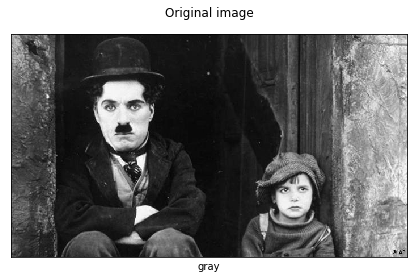

Corrupting the image...


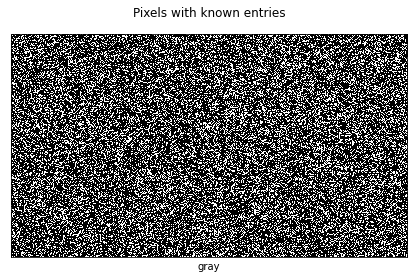

Shape of corrupted image: (394, 700)


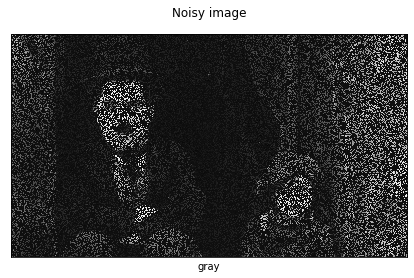

In [47]:
# path of the image
path = "./images/chaplin.jpg"
# load the image
image = Image.open(path).convert('L')
# convert image to numpy array
image = asarray(image)
m, n = image.shape
# sanity check
print("Shape of original image: {}".format(image.shape))
# plot image
plot_image(image, "Original image", "gray")
# define the rank of the final corrupted image 
k = 33
# define the probability that a given entry is missing in the final image
prob = 0.70
# corrupt the image
print ("Corrupting the image...")
image_noisy, mask = lowrank_missing(image, prob, k)
plot_image(mask, "Pixels with known entries", "gray")
# sanity check
print("Shape of corrupted image: {}".format(image_noisy.shape))
plot_image(image_noisy, "Noisy image", "gray")

### Image reconstruction in the noisy case via FISTA
In the noisy case we add gaussian noise to our matrix.

B shape :  (82563,)
A shape:  (82563, 275800)


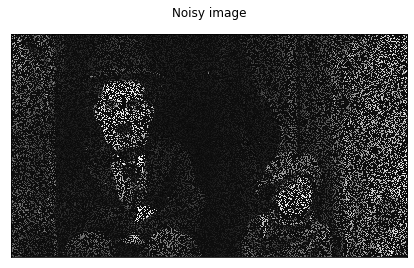

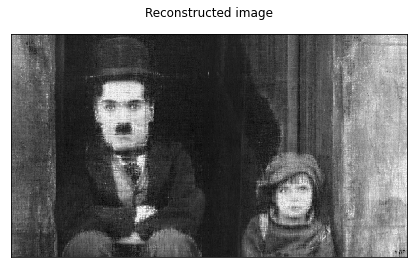

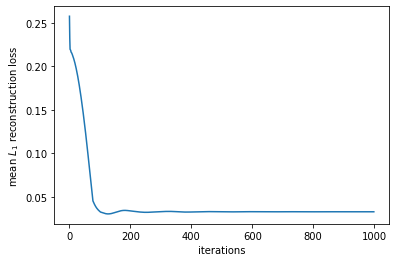

In [0]:
image_noisy, mask = lowrank_missing(image, prob, k, noise=1.0)

# get the values and the indexes of the known entries
omegaval = np.where(mask!=0)
omega = np.argwhere(mask!=0)
m, n = image_noisy.shape

# define the unidimensional vector B with the known entries
B = image_noisy[omegaval]
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
plot_image(image_noisy, title="Noisy image")
# run the DRS algorithm
recs = FISTA(A, B, m, n, lambda_=10, n_iter=1000, gather_iterations=True)
# plot the reconstructed image
plot_image(recs[-1], title="Reconstructed image", newshape=(m, n))
# plot the reconstruction_loss
plot_L1_loss(image, recs)

### Image reconstruction in the noiseless case via DRS


In [0]:
def DRS(A, B, m, n, iterations, gamma, gather_iterations=False):
    """
    Performs the Douglas–Rachford Splitting algorithm.
    Input:
        A: matrix A, that encodes the known entries.
        B: the known entries-vector.
        iteration: number of iterations to perform in the algorithm.
        gamma: threshold.
        gather_iterations: optional boolean to determine whether or not to
            return a list of zk in each iteration.
    Output:
        zk: unidimensional vector with the final approximation. 
            (only if gather_iterations == False)
        iteratives: list of the reconstructions at each iteration
            (only if gather_iterations == True)

    """
    iteratives = []

    zk = np.zeros(m*n)
    for k in range(0, iterations):
        xk = zk + A.T @ (B - A@zk)
        
        yk = singular_value_shrinkage(2*xk - zk , gamma, newshape=(m,n))
        zk = zk + yk - xk
        if gather_iterations:
            iteratives.append(zk)

    if not gather_iterations:
        return zk
    return iteratives

B shape :  (82718,)
A shape:  (82718, 275800)


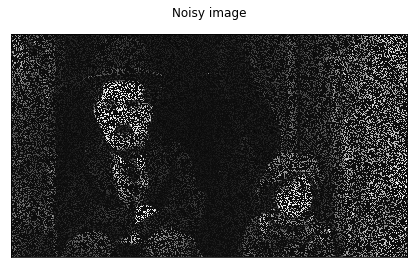

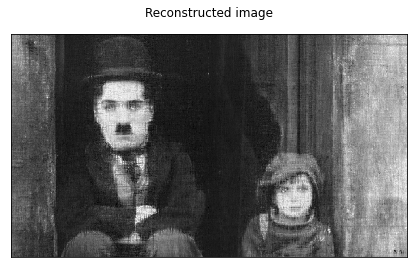

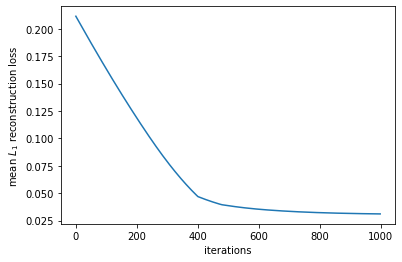

In [0]:
# get the values and the indexes of the known entries
omegaval = np.where(mask!=0)
omega = np.argwhere(mask!=0)
m, n = image_noisy.shape

# define the unidimensional vector B with the known entries
B = image_noisy[omegaval]
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
plot_image(image_noisy, title="Noisy image")
# run the DRS algorithm
recs = DRS(A, B, m, n, iterations = 1000, gamma = 20, gather_iterations=True)

# plot the reconstructed image
plot_image(recs[-1], title="Reconstructed image", newshape=(m, n))
# plot the reconstruction_loss
plot_L1_loss(image, recs)

# Netflix problem
Now we apply our algorithms to the netflix problem, i.e. predicting ratings for unrated movies

In [0]:
import os
import tarfile
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import numpy as np


def parse_customer_data(chunk):
    """
    Helper function to turn the customer data into usable data.
    Each line in our chunk corresponds to a rating from a customer
    and its date in the following format:
    CustomerID, Rating, Date
    
    returns:
        List of tuples containing the two elements 
        (CustomerID: int, Raring: int)
    """
    
    dat = []
    for cust_rating in chunk.split("\\n"):
        rating_data = cust_rating.split(",")
        if len(rating_data) == 3:
            
            customer_id, rating = map(int, rating_data[:2])
            
            #print(cust_rating, customer_id, rating)
            dat.append((customer_id, rating))
            
    return dat

def get_netflix_matrix(path, movie_id_range, customer_id_range, noise=0.0):
    """
    This generates the sparse netflix matrix, where the entries B_ij are the ratings
    of a movie j of customer i.
    
    Since the matrix is very big, we can specify a range of possible movie and customer
    values.
    
    Input:
        path: the path leading to the netflix .tar training file
        movie_id_range: a 2-tuple with min and max values for the movie id
              Movie ids range from 1 to 17770 sequentially
        customer_id_range: a 2-tuple with min and max values for the customer id
              CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users
    Output:
        B: the netflix matrix in sparse form (scipy.csc_matrix)
        mask: matrix with boolean values that indicates if the corresponding entry is known
              in the corrupted image (scipy.csc_matrix)
        customer_id_mapping: The mapping which maps a true user id to some smaller id.
              This mapping is necessary if the true user id needs to be recovered later.
    """
    
    assert 1 <= movie_id_range[0] and movie_id_range[1] <= 17770
    assert 1 <= customer_id_range[0] and customer_id_range[1] <= 2649429
    
    # since there are gaps in the user ids, we want to eliminate the gaps by
    # mapping these ids to a new range 1...480189
    customer_id_mapping = {}
    n_customer_ids = 0
    
    with tarfile.open(data_path) as tf:

        row = []
        col = []
        ratings = []

        for entry in tf:
            fileobj = tf.extractfile(entry)

            if fileobj is not None:
                data = str(fileobj.read())
                movie_id, customer_data = data.split(":")
                #print(entry)
                movie_id = int(movie_id[2:])
                customer_data = parse_customer_data(customer_data)

                #print(movie_id, customer_data)
                for customer_ in customer_data:
                    customer_id, customer_rating = int(customer_[0]), int(customer_[1])

                    if customer_id_range[0] <= customer_id <= customer_id_range[1] and movie_id_range[0] <= movie_id <= movie_id_range[1]:
                        if not customer_id in customer_id_mapping.keys():
                            customer_id_mapping[customer_id] = n_customer_ids
                            n_customer_ids += 1
                        
                        ratings.append(customer_rating)
                        col.append(customer_id_mapping[customer_id])
                        row.append(movie_id)
                        
        B = csr_matrix((ratings, (row, col)))
        mask = (B!=0)
        return B, mask, customer_id_mapping

In [30]:
movie_id_range = (200, 1200)
customer_id_range = (2000, int(2649429./700))

if not IN_COLAB:    
    notebook_path = os.getcwd()
    data_path = os.path.join(notebook_path, "download/training_set.tar")

    # To make the optimization a bit more feasible, we restrict our matrix size,
    # we restrict ourselves to a range of MovieIDs and CustomerIDs

    B_sparse, mask, customer_id_mapping = get_netflix_matrix(data_path, movie_id_range, customer_id_range)


    print("done")
else:
    !ls
    B_sparse=scipy.sparse.load_npz('netflix_matrix.npz')
    mask = (B_sparse!=0)

images		    project.ipynb  report.aux  report.pdf	  report.tex
netflix_matrix.npz  README.md	   report.log  report.synctex.gz


In [0]:
#import scipy
#scipy.sparse.save_npz('./netflix_matrix.npz', B_sparse)

(1201, 265)
B shape :  (3459,)
A shape:  (3459, 318265)


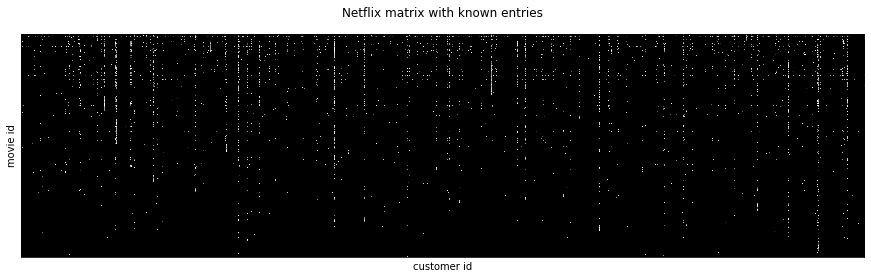

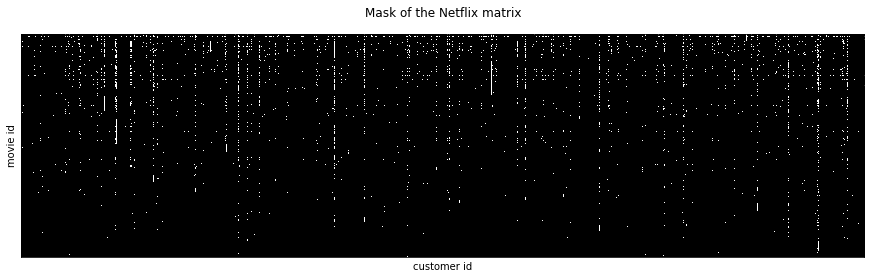

In [58]:
# get the values and the indexes of the known entries
B_dense = B_sparse.toarray()
print(B_dense.shape)
mask_dense = (B_dense !=0)
omegaval = np.where(mask_dense!=0)
omega = np.argwhere(mask_dense!=0)
m, n = B_dense.shape

# define the unidimensional vector B with the known entries
B = np.squeeze(np.asarray(B_dense[omegaval]))
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
plot_image(B_dense.T, "Netflix matrix with known entries", ylabel="movie id", xlabel="customer id", shift=200, vmin=0, vmax=5)
plot_image(mask_dense.T, "Mask of the Netflix matrix", ylabel="movie id", xlabel="customer id", shift=200, vmin=0, vmax=1)
# run the DRS algorithm
#rec = DRS(A, B, m, n, iterations = 200, gamma = .75).reshape(m, n)
# plot the reconstructed image
#plot_image(rec.T,"Predicted customer ratings", ylabel="movie id", xlabel="customer id")

# Bonus -- validation of the predictions & hyperparameter tuning
What we can do now is to validate the predicted ratings by selecting a few random known entries form our netflix matrix and moving them to a validation set. We can then try to see how well the predicted recommendation matches with the validation set.

Using this method we can tune the parameters of DRS and FISTA using a grid-seach.

In [0]:
def training_validaton_split(B, omega, validation_size):
    """
    splits the available data into a training and a validation set. Concretely this means that
    we take randomly selected known ratings from the netflix matrix and put them into our validation set
    
    Input:
        B: the constructed netflix matrix.
        omega: the index set of known entries in B.
        validation_size: the size of the validation set, i.e. how many known ratings we want to select.
        
    Output:
        B_train: the netflix matrix without the randomly selected entries.
        validation_ratings: a list of tuples of the form (customer_id, movie_id, rating)
        omega_train: the omega set where B_train is nonzero.
    """
    
    B_train = copy.deepcopy(B)
    validation_ratings = []
    
    rints = np.random.randint(omega.shape[0], size=validation_size)
    indices = omega[rints]    

    for i in range(validation_size):
        customer_id, movie_id = indices[i]
        rating = B[customer_id, movie_id]
        validation_ratings.append((customer_id, movie_id, rating))
        
        B_train[customer_id, movie_id] = 0

    
    omega_cpy = copy.deepcopy(omega)
    omega_train = np.delete(omega_cpy, rints, axis=0)
    #print("btrain: ", B_train.shape)
    

    return B_train, validation_ratings, omega_train


def get_loss(rec, validation_ratings):
    """
    calculate the mean error between the predicted and the true ratings
    """
    loss = 0.0
    for customer_id, movie_id, rating in validation_ratings:
        predicted_rating = rec[customer_id, movie_id]
        loss += np.abs(predicted_rating - rating)
    return loss/len(validation_ratings)

Now we can split up our known entires into a training and validation set and see how well the prediction aligns with the ground truth.

We start with DRS.

In [22]:
B_train, validation_ratings, omega_train = training_validaton_split(B_dense, omega, validation_size=100)
A = construct_A(omega_train, m, n)
mask_train = (B_train!=0)
omegaval_train = np.where(mask_train!=0)
B = B_train[omegaval_train]

# We apply DRS to the netflix-problem. The parameter gamma was obtainded
# via grid-seach
rec = DRS(A, B, m, n, iterations = 1000, gamma = 37).reshape(m, n)

# now we get the recommendations
for customer_id, movie_id, rating in validation_ratings:
    predicted_rating = rec[customer_id, movie_id]
    print("predicted: ", max(0, min(5, round(predicted_rating))), "ground truth: ", rating)

predicted:  3.0 ground truth:  3
predicted:  3.0 ground truth:  3
predicted:  3.0 ground truth:  4
predicted:  4.0 ground truth:  4
predicted:  3.0 ground truth:  5
predicted:  3.0 ground truth:  4
predicted:  2.0 ground truth:  5
predicted:  4.0 ground truth:  3
predicted:  2.0 ground truth:  2
predicted:  4.0 ground truth:  5
predicted:  3.0 ground truth:  3
predicted:  2.0 ground truth:  4
predicted:  1.0 ground truth:  4
predicted:  3.0 ground truth:  4
predicted:  2.0 ground truth:  5
predicted:  3.0 ground truth:  5
predicted:  3.0 ground truth:  3
predicted:  3.0 ground truth:  4
predicted:  3.0 ground truth:  3
predicted:  0 ground truth:  4
predicted:  4.0 ground truth:  4
predicted:  5 ground truth:  5
predicted:  3.0 ground truth:  5
predicted:  4.0 ground truth:  1
predicted:  4.0 ground truth:  3
predicted:  1.0 ground truth:  3
predicted:  4.0 ground truth:  3
predicted:  3.0 ground truth:  4
predicted:  2.0 ground truth:  2
predicted:  0 ground truth:  4
predicted:  3.0 

Now we draw the corresponding netflix matrix reconstructed using DRS

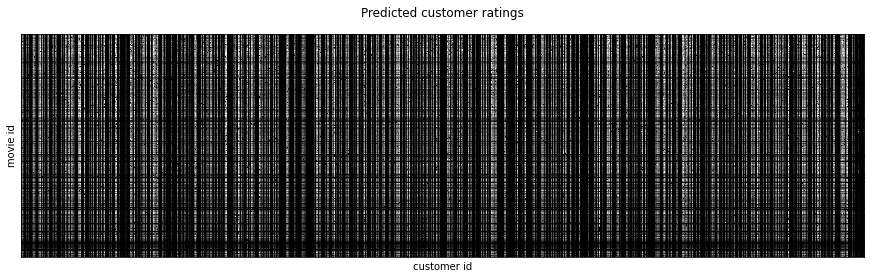

-36.00000000000002 14.736110011381895


In [60]:
# we restrict our plot to a range of [0,5] to see the results better, since the 
# values of the reconstruted matrix don't lie in this interval.
plot_image(rec.T,"Predicted customer ratings", ylabel="movie id", xlabel="customer id", shift=200, vmin=0, vmax=5)
print(rec.min(), rec.max())

---
Now we do the same for the noisy case with FISTA

In [61]:
B_train, validation_ratings, omega_train = training_validaton_split(B_dense, omega, validation_size=100)
A = construct_A(omega_train, m, n)
mask_train = (B_train!=0)
omegaval_train = np.where(mask_train!=0)

# since we are in the noisy case, we add some gaussian noise to the known values
B = B_train[omegaval_train]
noise = np.random.normal(loc=0, scale=1.0, size=B.shape)

# We apply DRS to the netflix-problem. The parameter gamma was obtainded
# via grid-seach
rec = FISTA(A, B + noise, m, n, n_iter= 1000, lambda_ = 2).reshape(m, n)

# now we get the recommendations
for customer_id, movie_id, rating in validation_ratings:
    predicted_rating = rec[customer_id, movie_id]
    print("predicted: ", max(0, min(5, round(predicted_rating))), "ground truth: ", rating)

predicted:  3.0 ground truth:  3
predicted:  2.0 ground truth:  4
predicted:  5 ground truth:  4
predicted:  2.0 ground truth:  5
predicted:  3.0 ground truth:  3
predicted:  3.0 ground truth:  1
predicted:  4.0 ground truth:  4
predicted:  3.0 ground truth:  4
predicted:  2.0 ground truth:  1
predicted:  2.0 ground truth:  4
predicted:  1.0 ground truth:  5
predicted:  4.0 ground truth:  4
predicted:  5 ground truth:  3
predicted:  4.0 ground truth:  5
predicted:  5 ground truth:  3
predicted:  5 ground truth:  4
predicted:  5 ground truth:  4
predicted:  3.0 ground truth:  4
predicted:  4.0 ground truth:  3
predicted:  3.0 ground truth:  3
predicted:  3.0 ground truth:  5
predicted:  2.0 ground truth:  3
predicted:  3.0 ground truth:  1
predicted:  4.0 ground truth:  5
predicted:  4.0 ground truth:  3
predicted:  2.0 ground truth:  4
predicted:  3.0 ground truth:  4
predicted:  1.0 ground truth:  4
predicted:  2.0 ground truth:  5
predicted:  4.0 ground truth:  3
predicted:  2.0 grou

Now we draw the corresponding netflix matrix reconstructed using FISTA

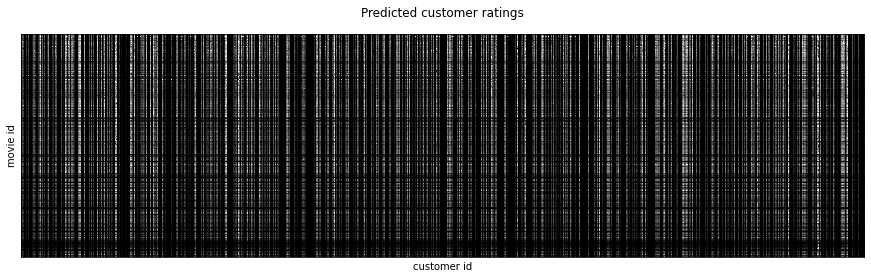

-1.1401629171777778 7.146176783748682


In [62]:
plot_image(rec.T,"Predicted customer ratings", ylabel="movie id", xlabel="customer id", shift=200, vmin=0, vmax=5)
# the true range of the reconstruction
print(rec.min(), rec.max())

---
## Hyperparameter tuning

In [0]:
# we consider a range of possible hyperparameters

def grid_search(parameters, validation_size, considered_splits, iterations, method):
    """
    perform a grid search for DRS to obtain the optimal hyperparameters.

    To get a better estimate of the loss, we consider many possible splits
    (i.e. considered_splits) and calculate the mean loss.

    We then select the parameter which yields the smallest mean loss.

    Input:
        parameters: the numpy array of possible parameters
        validation_size: how many known entries we select from the netflix matrix
        considered_splits: how many such splits we actually consider.
        iterations: number of iterations we want to run the specified method.
        method: the method we want to optmize (either "DRS" or "FISTA").
    Output:
        best_param: the parameter which yields the lowest mean loss.
    """
    
    best_param = parameters[0]
    best_loss = 1e10
    
    for param in parameters:
        
        mean_loss = 0.0
        # consider a variety of training-validation splits of the data
        for _ in range(considered_splits):
            
            # for DRS we want the noiseless case, for FISTA with noise
            if method == "DRS":
                noise = 0.0
            if method == "FISTA":
                noise = 1.0
                
            B_train, validation_ratings, omega_train = training_validaton_split(B_dense, omega, validation_size=validation_size)
            A = construct_A(omega_train, m, n)
            mask_train = (B_train!=0)
            omegaval_train = np.where(mask_train!=0)
            B = B_train[omegaval_train]
            
            if method == "DRS":
                rec = DRS(A, B, m, n, iterations=iterations, gamma=param).reshape(m, n)
            if method == "FISTA":
                noise_matrix = np.random.normal(loc=0, scale=1.0, size=B.shape)
                rec = FISTA(A, B+noise_matrix, m, n, lambda_=param, n_iter=iterations).reshape(m, n)
                
            mean_loss += get_loss(rec, validation_ratings)

        mean_loss /= considered_splits
        if mean_loss < best_loss:
            best_param = param
            best_loss = mean_loss
        print("current parameter: ", param, "with mean loss: ", mean_loss, "vs best parameter: ",best_param, "with best mean loss: ", best_loss)
    return best_param

In [11]:
parameters = np.arange(0,40,1)
print("grid:", parameters)
print("best parameter in grid: ", grid_search(parameters, validation_size=100, considered_splits=3, iterations=100, method="DRS"))

grid: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
current parameter:  0 with mean loss:  3.5100000000000713 vs best parameter:  0 with best mean loss:  3.5100000000000713
current parameter:  1 with mean loss:  2.253782049313364 vs best parameter:  1 with best mean loss:  2.253782049313364
current parameter:  2 with mean loss:  1.9297180404770196 vs best parameter:  2 with best mean loss:  1.9297180404770196
current parameter:  3 with mean loss:  1.729640672747082 vs best parameter:  3 with best mean loss:  1.729640672747082
current parameter:  4 with mean loss:  1.713435721246322 vs best parameter:  4 with best mean loss:  1.713435721246322
current parameter:  5 with mean loss:  1.6401545758303335 vs best parameter:  5 with best mean loss:  1.6401545758303335
current parameter:  6 with mean loss:  1.561642362945164 vs best parameter:  6 with best mean loss:  1.561642362945164
current parameter:  7 with mean 

In [0]:
parameters = np.arange(0,40,1)
print("grid:", parameters)
print("best parameter in grid: ", grid_search(parameters, validation_size=100, considered_splits=3, iterations=100, method="FISTA"))

grid: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
current parameter:  0 with mean loss:  3.443333333333657 vs best parameter:  0 with best mean loss:  3.443333333333657
current parameter:  1 with mean loss:  1.4874820374316682 vs best parameter:  1 with best mean loss:  1.4874820374316682
current parameter:  2 with mean loss:  1.3366105164605013 vs best parameter:  2 with best mean loss:  1.3366105164605013
current parameter:  3 with mean loss:  1.3874431963919307 vs best parameter:  2 with best mean loss:  1.3366105164605013
current parameter:  4 with mean loss:  1.4320790153334293 vs best parameter:  2 with best mean loss:  1.3366105164605013
current parameter:  5 with mean loss:  1.4706184304625554 vs best parameter:  2 with best mean loss:  1.3366105164605013
current parameter:  6 with mean loss:  1.433166868068499 vs best parameter:  2 with best mean loss:  1.3366105164605013
current parameter:  7 with 